# 🎬 Genre-Based Movie Recommendation System

##  Project Overview

This project is focused on building a **genre-based movie recommendation system** using a dataset of **Telugu movies**. The goal is to help users discover movies they might enjoy based on the **genres** they prefer. Rather than using collaborative filtering or user behavior data, this system uses **content-based filtering**, which relies on the movie's metadata — specifically, the `Genre` column.

##  Why Genre-Based?

Genres are one of the most intuitive and reliable ways to classify movies. A person who enjoys action movies is likely to enjoy other movies in that genre. By using genre tags as a basis for similarity, we can provide recommendations even for **new or lesser-known movies**, as long as their genres are known.

##  Approach

The project follows a systematic process:
1. **Data Preprocessing:** Handle missing values, clean irrelevant columns, and convert necessary fields (like `Year` and `Runtime`) to appropriate formats.
2. **Exploratory Data Analysis (EDA):** Analyze key trends such as genre distributions, ratings, and runtime to better understand the dataset.
3. **Content-Based Filtering:**
   - Convert genre text into numerical vectors using Count Vectorizer.
   - Compute **cosine similarity** between movies based on their genre vectors.
   - Given a movie title as input, recommend other movies with the most similar genre vectors.
4. **Result Presentation:** Create a function that takes a movie title as input and returns a list of recommended movies.

##  Objective

- Recommend top-N movies that are similar in genre to a user-specified movie.
- Provide a clean, interactive, and simple interface for testing recommendations.
- Focus on **Telugu cinema**, which is underrepresented in many global movie datasets.

##  Outcome

By the end of this project, we deliver a fully functional **content-based recommendation system** that suggests Telugu movies to users based on genre similarity. This system can serve as a foundation for more advanced models (like hybrid systems) that include collaborative filtering or deep learning.



In [385]:
#Import essential libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from collections import Counter

In [386]:
#import the dataset
df = pd.read_csv("TeluguMovies_dataset.csv")

In [387]:
#first 5 rows of the dataset
df.head()

,Unnamed: 0,Movie,Year,Certificate,Genre,Overview,Runtime,Rating,No.of.Ratings
0,0,Bahubali: The Beginning,2015.0,UA,"Action, Drama","In ancient India, an adventurous and darin...",159,8.1,99114
1,1,Baahubali 2: The Conclusion,2017.0,UA,"Action, Drama","When Shiva, the son of Bahubali, learns ab...",167,8.2,71458
2,2,1 - Nenokkadine,2014.0,UA,"Action, Thriller",A rock star must overcome his psychologica...,170,8.1,42372
3,3,Dhoom:3,2013.0,UA,"Action, Thriller","When Sahir, a circus entertainer trained i...",172,5.4,42112
4,4,Ra.One,2011.0,U,"Action, Adventure, Sci-Fi",When the titular antagonist of an action g...,156,4.6,37211


In [388]:
#last 5 rows of the dataset
df.tail()

,Unnamed: 0,Movie,Year,Certificate,Genre,Overview,Runtime,Rating,No.of.Ratings
1395,1395,Maro Monagadu,1985.0,NaN,NaN,NaN,0,8.6,49
1396,1396,Jakkanna,2016.0,NaN,"Comedy, Drama",The movie is about an attempt by Sunil the...,0,6.3,49
1397,1397,Muvva Gopaludu,1987.0,NaN,"Drama, Romance",Muvva Gopaludu is a 1987 Indian Telugu fil...,137,7.8,49
1398,1398,Ninney Ishta Paddaanu,2003.0,U,NaN,Hero Charan (Tarun) a middle class family ...,0,5.9,49
1399,1399,9 Nelalu,2001.0,U,Drama,"Surendra marries Savitri, an orphan. In a ...",0,7.3,49


In [389]:
#null values in the dataset
df.isnull().sum()

Unnamed: 0         0
Movie              0
Year              48
Certificate      449
Genre             11
Overview         179
Runtime            0
Rating             0
No.of.Ratings      0
dtype: int64

- We have found null values in `Year`, `Certificate`, `Genre` and `Overview`.
- We will later find appropriate imputation method for each column in the analysis.

In [391]:
#shape of the dataset
df.shape

(1400, 9)

- There are 1400 columns and 9 rows.

In [397]:
#datatypes and non null values of the columns
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1400 entries, 0 to 1399
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Unnamed: 0     1400 non-null   int64  
 1   Movie          1400 non-null   object 
 2   Year           1352 non-null   float64
 3   Certificate    951 non-null    object 
 4   Genre          1389 non-null   object 
 5   Overview       1221 non-null   object 
 6   Runtime        1400 non-null   int64  
 7   Rating         1400 non-null   float64
 8   No.of.Ratings  1400 non-null   int64  
dtypes: float64(2), int64(3), object(4)
memory usage: 98.6+ KB


- `Year` column should be Date dtype instead of float.


In [399]:
#checking the range of values for numeric columns
df.describe()

,Unnamed: 0,Year,Runtime,Rating,No.of.Ratings
count,1400.0000,1352.000000,1400.000000,1400.000000,1400.000000
mean,699.5000,2005.013314,121.764286,6.317214,1214.755714
std,404.2895,13.148859,55.925792,1.314660,4328.073152
min,0.0000,1932.000000,0.000000,1.000000,49.000000
25%,349.7500,1997.000000,123.000000,5.500000,92.000000
50%,699.5000,2009.000000,141.000000,6.500000,255.500000
75%,1049.2500,2015.000000,154.000000,7.300000,829.000000
max,1399.0000,2020.000000,300.000000,9.500000,99114.000000


## 1. Data Preprocessing & Cleaning

Before building the recommendation engine, it's essential to clean the dataset and handle missing or inconsistent entries.

We'll take care of:
- Removing irrelevant columns
- Dealing with missing values in `Genre`, `Year`, `Certificate`, and `Overview`
- Fixing incorrect `Runtime` entries

In [402]:
# Drop columns not useful for analysis
df.drop(columns=['Unnamed: 0'], inplace=True)

- `Unnamed: 0` column has no relavance to the analysis and it can be removed.

In [405]:
#check for the null value count in each column
df.isnull().sum()

Movie              0
Year              48
Certificate      449
Genre             11
Overview         179
Runtime            0
Rating             0
No.of.Ratings      0
dtype: int64

**1. Year column:**
- Our focus is on Genre column. So, null values in Year column will not impact the system.
- We cannot even impute any other values as it is Date dtype.
- So we will replace the missing cells with 'Unknown', as this column will be useful in displaying th movie information to the user.

In [408]:
df['Year'] = df['Year'].astype('Int64')

In [409]:
df['Year'] = df['Year'].astype(str).replace('<NA>', 'Unknown')

In [411]:
df['Year'].isnull().sum()

0

In [413]:
df.head()

,Movie,Year,Certificate,Genre,Overview,Runtime,Rating,No.of.Ratings
0,Bahubali: The Beginning,2015,UA,"Action, Drama","In ancient India, an adventurous and darin...",159,8.1,99114
1,Baahubali 2: The Conclusion,2017,UA,"Action, Drama","When Shiva, the son of Bahubali, learns ab...",167,8.2,71458
2,1 - Nenokkadine,2014,UA,"Action, Thriller",A rock star must overcome his psychologica...,170,8.1,42372
3,Dhoom:3,2013,UA,"Action, Thriller","When Sahir, a circus entertainer trained i...",172,5.4,42112
4,Ra.One,2011,U,"Action, Adventure, Sci-Fi",When the titular antagonist of an action g...,156,4.6,37211


**2. Certificate and Overview Column:**
- We will replace the null values in Certification column with mode grouping them by genres.
- we will replace null values in Overiview column with `Unknown`.

In [415]:
df['Certificate'] = df.groupby('Genre')['Certificate'].transform(lambda x: x.fillna(x.mode().iloc[0] if not x.mode().empty else 'Unknown'))

In [416]:
df['Overview'] = df['Overview'].fillna('Unknown')

**3. Genre Column:**
- `Genre` is the important colum  in our project and only way handling these missing values is directly removing those rows. 

In [418]:
df = df.dropna(subset = ['Genre'])

In [419]:
df.isnull().sum()

Movie            0
Year             0
Certificate      0
Genre            0
Overview         0
Runtime          0
Rating           0
No.of.Ratings    0
dtype: int64

In [420]:
df.head()

,Movie,Year,Certificate,Genre,Overview,Runtime,Rating,No.of.Ratings
0,Bahubali: The Beginning,2015,UA,"Action, Drama","In ancient India, an adventurous and darin...",159,8.1,99114
1,Baahubali 2: The Conclusion,2017,UA,"Action, Drama","When Shiva, the son of Bahubali, learns ab...",167,8.2,71458
2,1 - Nenokkadine,2014,UA,"Action, Thriller",A rock star must overcome his psychologica...,170,8.1,42372
3,Dhoom:3,2013,UA,"Action, Thriller","When Sahir, a circus entertainer trained i...",172,5.4,42112
4,Ra.One,2011,U,"Action, Adventure, Sci-Fi",When the titular antagonist of an action g...,156,4.6,37211


In [421]:
df.dtypes

Movie             object
Year              object
Certificate       object
Genre             object
Overview          object
Runtime            int64
Rating           float64
No.of.Ratings      int64
dtype: object

In [422]:
df.duplicated().sum()

0

In [423]:
df[df['Runtime'] == 'Unknown']

,Movie,Year,Certificate,Genre,Overview,Runtime,Rating,No.of.Ratings


## 2. Exploratory Data Analysis (EDA)

To understand our dataset better, we analyze:

- Movie genres and their distribution
- Ratings and runtime patterns
- Release year trends

### Rating Distribution and Outliers

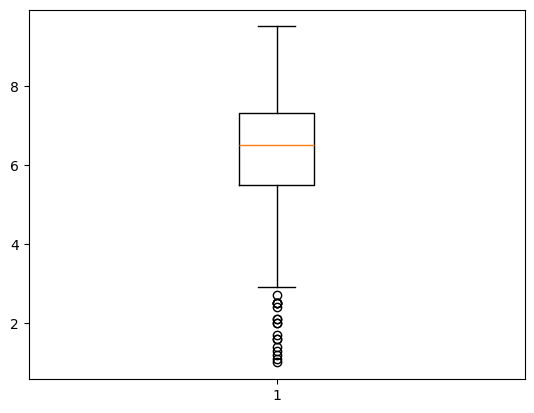

In [426]:
plt.boxplot(df.Rating)
plt.show()

In [427]:
df['Rating'].describe()

count    1389.000000
mean        6.305472
std         1.310784
min         1.000000
25%         5.500000
50%         6.500000
75%         7.300000
max         9.500000
Name: Rating, dtype: float64

- The range of Rating is `1 - 9.5` and is in the correct range. So there are no actual outliers in the column.

### Runtime Distribution (Excluding Unknowns)

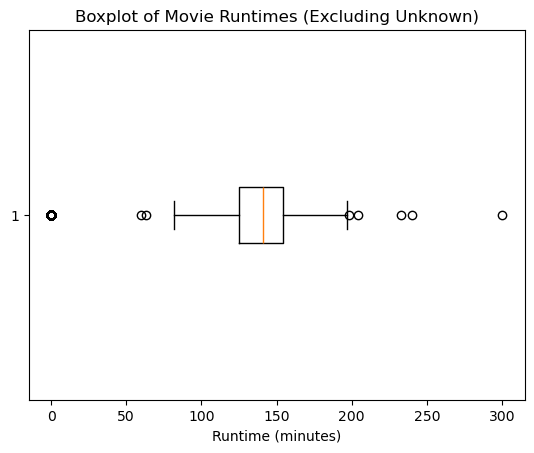

In [434]:
runtime_data = df[df['Runtime'] != 'Unknown']['Runtime'].astype(int)
plt.boxplot(runtime_data, vert=False)
plt.title('Boxplot of Movie Runtimes (Excluding Unknown)')
plt.xlabel('Runtime (minutes)')
plt.show()

In [435]:
df[df['Runtime'] > 200]

,Movie,Year,Certificate,Genre,Overview,Runtime,Rating,No.of.Ratings
203,Athidhi,2007,A,Action,Athidi(Mahesh Babu) is falsely convicted f...,300,5.5,1691
468,Daana Veera Soora Karna,1977,U,"Action, Drama, Fantasy","Abandoned at birth, brave and loyal Karna ...",233,8.8,530
477,Veera,1994,U,"Comedy, Romance",A talented musician from a village migrate...,240,6.6,515
1215,Tenali Ramakrishna,Unknown,U,"Comedy, Drama",This film is based on a famous Telugu poet...,204,7.9,67


In [436]:
df.loc[df['Movie'] == 'Athidhi', 'Runtime'] = 162
df.loc[df['Movie'] == 'Veera', 'Runtime'] = 164

- Identified outliers in the 'Runtime' column (movies > 200 mins).
- Manually verified these records using external sources (IMDb/Google).
-  Found 2 incorrect values and corrected/removed them for accurate analysis.


In [439]:
df['Runtime'] = np.where(df['Runtime'] == 0, 'Unknown', df['Runtime'].astype(str))


- There are many records with runtime '0', that means runtime is 'Unknown'. So it is better replacing the 0 runtime wth Unknown.

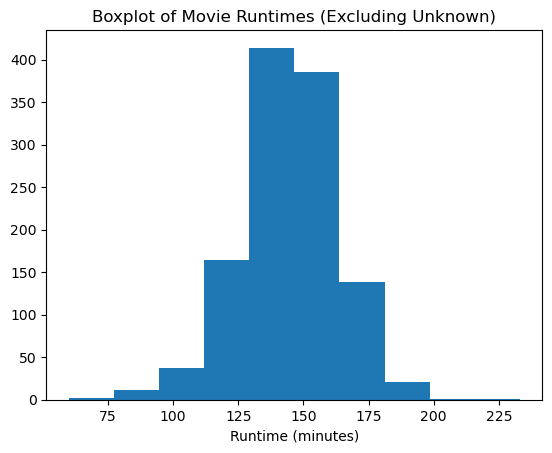

In [447]:
runtime_data = df[df['Runtime'] != 'Unknown']['Runtime'].astype(int)
plt.hist(runtime_data)
plt.title('Boxplot of Movie Runtimes (Excluding Unknown)')
plt.xlabel('Runtime (minutes)')
plt.show()

### Release Year Trends

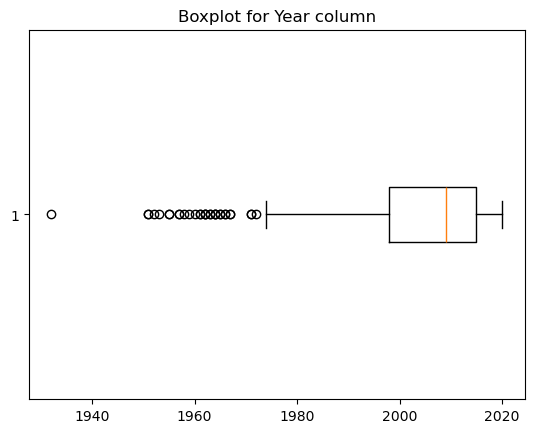

In [449]:
year_data = df[df['Year'] != 'Unknown']['Year'].astype(int)
plt.boxplot(year_data, vert = False)
plt.title('Boxplot for Year column')
plt.show()

In [450]:
df_known_years = df[df['Year'] != 'Unknown'].copy()
df_known_years.loc[:, 'Year'] = df_known_years['Year'].astype(int)
df_known_years[df_known_years['Year'] < 1960]


,Movie,Year,Certificate,Genre,Overview,Runtime,Rating,No.of.Ratings
92,Maya Bazaar,1957,U,"Comedy, Drama, Family",Balarama promises Subhadra to get his daug...,192,9.2,3733
378,Missamma,1955,U,"Comedy, Drama, Family",Two unemployed college graduates from Madr...,181,8.5,754
437,Pathala Bhairavi,1951,U,"Action, Adventure, Family","A poor man, in love with a princess, is pe...",192,8.5,592
732,Devadasu,1953,U,"Drama, Family, Musical","Adapted from a popular Bengali novel, Deva...",191,7.4,235
878,Malliswari,1951,U,"Drama, History, Musical",Nagaraju and Malliswari want to get marrie...,194,7.0,144
893,Bhookailas,1958,U,"Drama, Musical","Ravana, the king of Lanka gets tricked by ...",174,7.1,138
991,Kanchana,1952,U,Drama,Unknown,165,7.0,106
1061,Appu Chesi Pappu Koodu,1959,U,"Comedy, Drama",Ramadasu wants his son to marry Manjari to...,176,8.0,91
1069,Kanyasulkam,1955,U,Drama,Kanyasulkam is an adaptation of the popula...,167,7.9,90
1224,Bhakta Prahlada,1932,U,"Drama, Fantasy",Bhakta Prahlada is the first full length T...,108,7.1,66


- Verified 'Year' values via external sources (IMDb/Wikipedia)
- All 11 movies have correct release years; no further corrections needed.


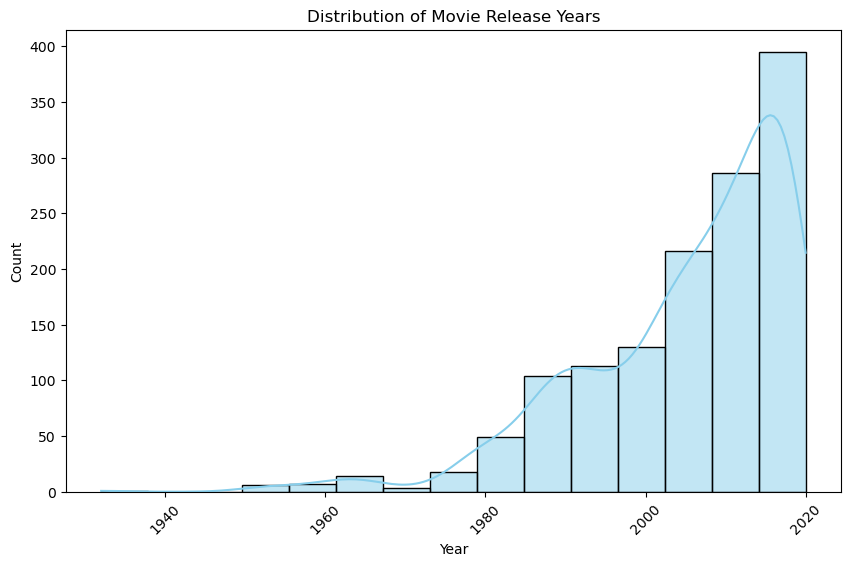

In [453]:
df_known_years['Year'] = df_known_years['Year'].astype(int)
plt.figure(figsize=(10, 6))
sns.histplot(df_known_years['Year'], bins=15, kde=True, color='skyblue')
plt.title('Distribution of Movie Release Years')
plt.xlabel('Year')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()


### Certificate Distribution

In [456]:
df.Certificate.value_counts()

Certificate
U            751
UA           441
A            154
Unknown       26
Unrated        7
Not Rated      4
U/A            4
PG-13          2
Name: count, dtype: int64

In [458]:
df['Certificate'] = df['Certificate'].replace('PG-13','U/A')
df['Certificate'] = df['Certificate'].replace('Unrated','Unknown')
df['Certificate'] = df['Certificate'].replace('Not Rated','Unknown')

In [459]:
df.Certificate.value_counts()

Certificate
U          751
UA         441
A          154
Unknown     37
U/A          6
Name: count, dtype: int64

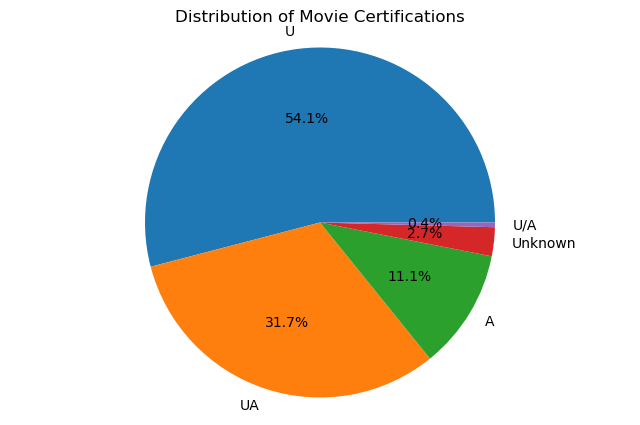

In [461]:
plt.figure(figsize=(8, 5))
plt.pie(df.Certificate.value_counts(), labels=df.Certificate.value_counts().index, autopct='%1.1f%%')
plt.title('Distribution of Movie Certifications')
plt.axis('equal')
plt.show()

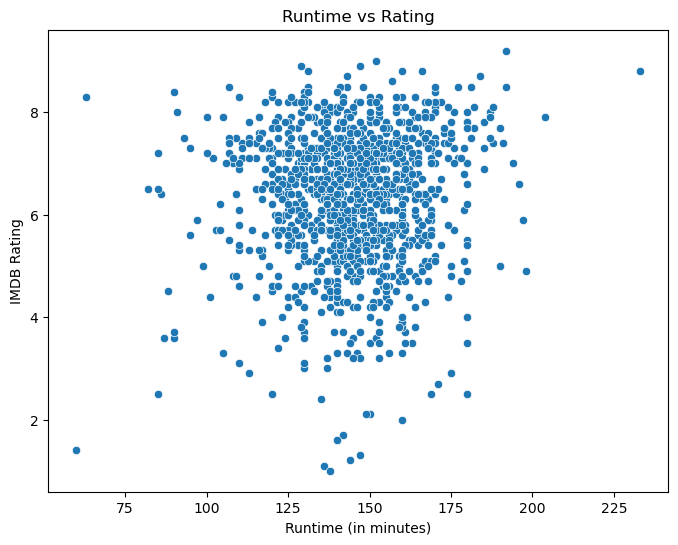

In [462]:
df_clean = df[df['Runtime'] != 'Unknown'].copy()
df_clean['Runtime'] = df_clean['Runtime'].astype(int)
plt.figure(figsize=(8, 6))
sns.scatterplot(data=df_clean, x='Runtime', y='Rating')
plt.title('Runtime vs Rating')
plt.xlabel('Runtime (in minutes)')
plt.ylabel('IMDB Rating')
plt.show()


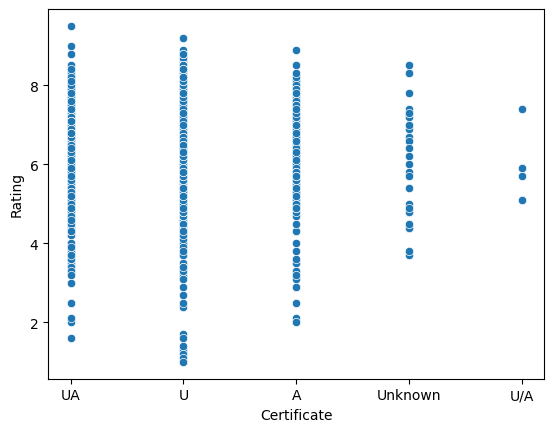

In [463]:
sns.scatterplot(data=df, x='Certificate', y='Rating')
plt.show()

## 3. Feature Engineering

We now transform raw textual fields into numerical formats using **TF-IDF Vectorization**, a technique that converts text into feature vectors.

We'll create:
- TF-IDF matrix for genres
- TF-IDF matrix for plot summaries
- Cosine similarity matrices to measure movie-to-movie distance

In [465]:
df['Genre'] = df['Genre'].apply(lambda x: [genre.strip() for genre in str(x).split(',')])

In [466]:
df.head()

,Movie,Year,Certificate,Genre,Overview,Runtime,Rating,No.of.Ratings
0,Bahubali: The Beginning,2015,UA,"[Action, Drama]","In ancient India, an adventurous and darin...",159,8.1,99114
1,Baahubali 2: The Conclusion,2017,UA,"[Action, Drama]","When Shiva, the son of Bahubali, learns ab...",167,8.2,71458
2,1 - Nenokkadine,2014,UA,"[Action, Thriller]",A rock star must overcome his psychologica...,170,8.1,42372
3,Dhoom:3,2013,UA,"[Action, Thriller]","When Sahir, a circus entertainer trained i...",172,5.4,42112
4,Ra.One,2011,U,"[Action, Adventure, Sci-Fi]",When the titular antagonist of an action g...,156,4.6,37211


In [467]:
from collections import Counter
all_genres = [genre for sublist in df['Genre'] for genre in sublist]
genre_counts = Counter(all_genres)
print(f"Total unique genres: {len(genre_counts)}")
print("Sample genre counts:", genre_counts.most_common(10))


Total unique genres: 20
Sample genre counts: [('Drama', 708), ('Action', 630), ('Comedy', 420), ('Romance', 354), ('Thriller', 173), ('Crime', 84), ('Family', 83), ('Fantasy', 52), ('Musical', 52), ('Horror', 40)]


In [468]:
df['Overview'] = df['Overview'].fillna('unknown')
df['Overview_clean'] = df['Overview'].str.lower().str.replace('[^a-zA-Z0-9 ]', '', regex=True)


In [469]:
df.head()

,Movie,Year,Certificate,Genre,Overview,Runtime,Rating,No.of.Ratings,Overview_clean
0,Bahubali: The Beginning,2015,UA,"[Action, Drama]","In ancient India, an adventurous and darin...",159,8.1,99114,in ancient india an adventurous and daring...
1,Baahubali 2: The Conclusion,2017,UA,"[Action, Drama]","When Shiva, the son of Bahubali, learns ab...",167,8.2,71458,when shiva the son of bahubali learns abou...
2,1 - Nenokkadine,2014,UA,"[Action, Thriller]",A rock star must overcome his psychologica...,170,8.1,42372,a rock star must overcome his psychologica...
3,Dhoom:3,2013,UA,"[Action, Thriller]","When Sahir, a circus entertainer trained i...",172,5.4,42112,when sahir a circus entertainer trained in...
4,Ra.One,2011,U,"[Action, Adventure, Sci-Fi]",When the titular antagonist of an action g...,156,4.6,37211,when the titular antagonist of an action g...


In [470]:
# For genre TF-IDF
df['Genre_str'] = df['Genre'].apply(lambda x: ' '.join(x))

# For summary embeddings (prep for vectorization in the next steps)
summaries = df['Overview_clean'].tolist()

In [471]:
df.head()

,Movie,Year,Certificate,Genre,Overview,Runtime,Rating,No.of.Ratings,Overview_clean,Genre_str
0,Bahubali: The Beginning,2015,UA,"[Action, Drama]","In ancient India, an adventurous and darin...",159,8.1,99114,in ancient india an adventurous and daring...,Action Drama
1,Baahubali 2: The Conclusion,2017,UA,"[Action, Drama]","When Shiva, the son of Bahubali, learns ab...",167,8.2,71458,when shiva the son of bahubali learns abou...,Action Drama
2,1 - Nenokkadine,2014,UA,"[Action, Thriller]",A rock star must overcome his psychologica...,170,8.1,42372,a rock star must overcome his psychologica...,Action Thriller
3,Dhoom:3,2013,UA,"[Action, Thriller]","When Sahir, a circus entertainer trained i...",172,5.4,42112,when sahir a circus entertainer trained in...,Action Thriller
4,Ra.One,2011,U,"[Action, Adventure, Sci-Fi]",When the titular antagonist of an action g...,156,4.6,37211,when the titular antagonist of an action g...,Action Adventure Sci-Fi


In [472]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Each movie’s genres as a space-separated string
genre_corpus = df['Genre_str'].tolist()

genre_vectorizer = TfidfVectorizer(token_pattern=r'(?u)\b[\w-]+\b')
genre_tfidf_matrix = genre_vectorizer.fit_transform(genre_corpus)
genre_feature_names = genre_vectorizer.get_feature_names_out()
genre_feature_names

array(['action', 'adventure', 'animation', 'biography', 'comedy', 'crime',
       'drama', 'family', 'fantasy', 'history', 'horror', 'music',
       'musical', 'mystery', 'romance', 'sci-fi', 'sport', 'thriller',
       'war', 'western'], dtype=object)

In [473]:
Overview_vectorizer = TfidfVectorizer(stop_words='english', max_features=3000)
Overview_tfidf_matrix = Overview_vectorizer.fit_transform(df['Overview_clean'])
Overview_feature_names = Overview_vectorizer.get_feature_names_out()
Overview_feature_names

array(['10', '12', '13', ..., 'youth', 'youthful', 'yvs'], dtype=object)

In [474]:
from sklearn.metrics.pairwise import cosine_similarity

Overview_sim_matrix = cosine_similarity(Overview_tfidf_matrix)
genre_sim_matrix = cosine_similarity(genre_tfidf_matrix)


## 4. Recommendation Engine

This section contains:
- A genre-based recommender that selects top-rated movies within a selected genre using TF-IDF scores.
- An overview-based recommender that finds movies similar in plot/theme to a given title using cosine similarity on TF-IDF vectors of summaries.

In [479]:
def get_similar_movies_by_Overview(movie_idx, top_n=5):
    # Returns indices of top_n most similar movies, excluding the movie itself
    sims = Overview_sim_matrix[movie_idx]
    similar_indices = sims.argsort()[::-1][1:top_n+1]
    return similar_indices


In [480]:
def get_movies_with_high_tfidf(selected_genre, threshold=0.8):
    # Find movies where the TF-IDF score for the selected genre is in the top 20%
    if selected_genre not in genre_feature_names:
        return []
    genre_idx = list(genre_feature_names).index(selected_genre)
    scores = genre_tfidf_matrix[:, genre_idx].toarray().flatten()
    score_thresh = pd.Series(scores).quantile(threshold)
    return list(df.index[scores >= score_thresh])


In [481]:
def recommend_movies(selected_genre, top_n=10):
    """
    Recommends top movies for a given genre, sorted by rating and TF-IDF score.
    
    Args:
        selected_genre (str): The genre to filter movies by.
        top_n (int): Number of top movies to return (default 10).
    
    Returns:
        pd.DataFrame: DataFrame with columns ['Movie', 'Genre', 'Rating', 'Overview'].
    """
    # Use lower-case for genre to avoid mismatch
    high_tfidf_indices = get_movies_with_high_tfidf(selected_genre.lower(), threshold=0.8)
    filtered_df = df.loc[high_tfidf_indices].copy()
    if filtered_df.empty:
        return pd.DataFrame(columns=['Movie', 'Genre', 'Rating', 'Overview'])
    # Filter movies containing the selected genre
    mask = filtered_df['Genre'].apply(lambda genres: selected_genre.lower() in [g.lower() for g in genres])
    filtered_df = filtered_df[mask].copy()
    if filtered_df.empty:
        return pd.DataFrame(columns=['Movie', 'Genre', 'Rating', 'Overview'])
    # Get genre TF-IDF score for the selected genre
    try:
        genre_idx = list(genre_feature_names).index(selected_genre.lower())
        filtered_df['tfidf_score'] = genre_tfidf_matrix[filtered_df.index, genre_idx].toarray().flatten()
    except ValueError:
        # If genre not in TF-IDF vocabulary, use rating only
        filtered_df['tfidf_score'] = 0
    # Sort by rating, then by tfidf_score as a tie-breaker
    filtered_df = filtered_df.sort_values(['Rating', 'tfidf_score'], ascending=[False, False])
    return filtered_df[['Movie', 'Genre', 'Rating', 'Overview']].head(top_n)

In [482]:
def you_may_also_like(selected_movie_title, top_n=5, min_rating=6.0):
    movie_idx = df.index[df['Movie'] == selected_movie_title][0]
    similar_idxs = get_similar_movies_by_Overview(movie_idx, top_n=50)  # Get more candidates
    recs = df.iloc[similar_idxs][['Movie', 'Genre', 'Rating', 'Overview']]
    recs = recs[recs['Rating'] >= min_rating]  # Filter by min_rating
    recs['Rec_Reason'] = f"Shares similar themes with '{selected_movie_title}'"
    # Sort by similarity (already sorted), then by rating
    recs = recs.sort_values('Rating', ascending=False)
    return recs.head(top_n)


## 5. Graphical User Interface (GUI)

We build an interactive interface using `tkinter` to let users:
- Select a genre and view top recommended movies
- View detailed information for any selected movie
- Get content-based suggestions under “You May Also Like”

In [484]:
import tkinter as tk
from tkinter import ttk
import pandas as pd

# Use your actual DataFrame
data = df.copy()

# Prepare genre-movie dictionary and unique genre list
unique_genres = sorted({g.strip() for genres in data['Genre'] for g in genres})
genre_movies_dict = {genre: [] for genre in unique_genres}
for idx, row in data.iterrows():
    for genre in row['Genre']:
        genre_movies_dict[genre.strip()].append(row)

# Create GUI
window = tk.Tk()
window.title("Movie Recommender")

# Genre dropdown
genre_label = ttk.Label(window, text="Select Genre:")
genre_label.pack()
genre_var = tk.StringVar()
genre_dropdown = ttk.Combobox(window, textvariable=genre_var, values=unique_genres, state="readonly")
genre_dropdown.pack()

# Recommend button
recommend_button = ttk.Button(window, text="Recommend Movies")
recommend_button.pack()

# Main recommendations table
columns = ("Sl.No", "Movie Name", "Year", "Rating")
movie_tree = ttk.Treeview(window, columns=columns, show="headings", height=8)
for col in columns:
    movie_tree.heading(col, text=col)
    movie_tree.column(col, width=300 if col == "Movie Name" else 100)
movie_tree.pack()

details_label = ttk.Label(window, text="Movie Details:")
details_label.pack()
details_text = ttk.Label(window, text="", wraplength=400, justify="left")
details_text.pack()

# "You May Also Like" widgets
ymal_label = ttk.Label(window, text='"You May Also Like"')
ymal_tree = ttk.Treeview(window, columns=columns, show="headings", height=4)
for col in columns:
    ymal_tree.heading(col, text=col)
    ymal_tree.column(col, width=300 if col == "Movie Name" else 100)
ymal_details_label = ttk.Label(window, text="Details for 'You May Also Like':")
ymal_details_text = ttk.Label(window, text="", wraplength=400, justify="left")

result_label = ttk.Label(window, text="")
result_label.pack()

# Hide "You May Also Like" at startup
ymal_label.pack_forget()
ymal_tree.pack_forget()
ymal_details_label.pack_forget()
ymal_details_text.pack_forget()

def handle_recommend_movies():
    """
    Handles the 'Recommend Movies' button click, displaying top 10 movies for the selected genre.
    """
    selected_genre = genre_var.get()
    if not selected_genre:
        result_label.config(text="Please select a genre.")
        return
    # Use the backend recommend_movies function to get top 10 movies
    recommended = recommend_movies(selected_genre, top_n=10)
    if recommended.empty:
        result_label.config(text=f"No movies found for {selected_genre}.")
        for item in movie_tree.get_children():
            movie_tree.delete(item)
        details_text.config(text="")
        ymal_label.pack_forget()
        ymal_tree.pack_forget()
        ymal_details_label.pack_forget()
        ymal_details_text.pack_forget()
        return
    # Clear and fill main table
    for item in movie_tree.get_children():
        movie_tree.delete(item)
    for i, row in enumerate(recommended.itertuples(), 1):
        year = data[data['Movie'] == row.Movie]['Year'].iloc[0]
        movie_tree.insert("", "end", values=(i, row.Movie, year, row.Rating))
    result_label.config(text=f"Top {len(recommended)} movies for {selected_genre}.")
    details_text.config(text="")
    ymal_label.pack_forget()
    ymal_tree.pack_forget()
    ymal_details_label.pack_forget()
    ymal_details_text.pack_forget()

def display_movie_details(event):
    """
    Displays details of a selected movie and populates 'You May Also Like' with similar movies.
    """
    selected = movie_tree.selection()
    if selected:
        item = movie_tree.item(selected, "values")
        movie_name = item[1]  # Movie Name is the second column
        try:
            row = data[data['Movie'] == movie_name].iloc[0]
            runtime = row['Runtime'] if row['Runtime'] != 'Unknown' else 'Unknown'
            details_text.config(text=f"Year: {row['Year']}\n"
                                    f"Genre: {', '.join(row['Genre'])}\n"
                                    f"Certificate: {row['Certificate']}\n"
                                    f"Overview: {row['Overview']}\n"
                                    f"Runtime: {runtime}\n"
                                    f"Rating: {row['Rating']}\n")
            # Use you_may_also_like for "You May Also Like" recommendations
            similar = you_may_also_like(movie_name, top_n=4, min_rating=6.0)
            for item in ymal_tree.get_children():
                ymal_tree.delete(item)
            for i, simrow in enumerate(similar.itertuples(), 1):
                year = data[data['Movie'] == simrow.Movie]['Year'].iloc[0]
                ymal_tree.insert("", "end", values=(i, simrow.Movie, year, simrow.Rating))
            ymal_label.pack()
            ymal_tree.pack()
            ymal_details_label.pack()
            ymal_details_text.pack()
        except IndexError:
            details_text.config(text="Error: Movie not found in dataset.")
            ymal_label.pack_forget()
            ymal_tree.pack_forget()
            ymal_details_label.pack_forget()
            ymal_details_text.pack_forget()
    else:
        details_text.config(text="")
        ymal_label.pack_forget()
        ymal_tree.pack_forget()
        ymal_details_label.pack_forget()
        ymal_details_text.pack_forget()

def display_ymal_details(event):
    """
    Displays details of a selected movie from the 'You May Also Like' table.
    """
    selected = ymal_tree.selection()
    if selected:
        item = ymal_tree.item(selected, "values")
        movie_name = item[1]  # Movie Name is the second column
        try:
            row = data[data['Movie'] == movie_name].iloc[0]
            runtime = row['Runtime'] if row['Runtime'] != 'Unknown' else 'Unknown'
            ymal_details_text.config(text=f"Year: {row['Year']}\n"
                                         f"Genre: {', '.join(row['Genre'])}\n"
                                         f"Certificate: {row['Certificate']}\n"
                                         f"Overview: {row['Overview']}\n"
                                         f"Runtime: {runtime}\n"
                                         f"Rating: {row['Rating']}\n")
        except IndexError:
            ymal_details_text.config(text="Error: Movie not found in dataset.")
    else:
        ymal_details_text.config(text="")

# Bind events
recommend_button.config(command=handle_recommend_movies)
movie_tree.bind("<<TreeviewSelect>>", display_movie_details)
ymal_tree.bind("<<TreeviewSelect>>", display_ymal_details)

# Start the GUI
window.mainloop()

## 6. Summary & Next Steps

This notebook presented a genre-based movie recommendation engine tailored for Telugu cinema using content-based filtering. Here's a quick recap of what we achieved:

- 📊 **Data Cleaning**: Handled missing and inconsistent values in movie metadata.
- 📈 **EDA**: Analyzed genre popularity, runtime, and release year trends.
- 🧠 **Feature Engineering**: Vectorized genre and overview data using TF-IDF.
- 🧮 **Similarity Computation**: Calculated cosine similarity for genre and plot embeddings.
- 🎬 **Recommendation System**: Built functions to recommend movies by genre and content.
- 🖥️ **Interactive GUI**: Enabled user interaction through a Tkinter interface.

###  Strengths
- Doesn't rely on user history, so it works well for cold-start scenarios.
- Fully localized to Telugu content—a niche often underrepresented.
- Transparent and explainable logic (TF-IDF + similarity).

###  Potential Improvements
- Incorporate collaborative filtering to account for user behavior.
- Add external metadata (director, actors, keywords) for hybrid recommendations.
- Replace TF-IDF with transformer-based embeddings for deeper plot understanding.
- Deploy the system as a web app using Streamlit or Flask.
